
# Patient Recovery Prediction – Full Analysis and Model Comparison

This notebook predicts the **Recovery Index**. It starts with a quick data exploration, then builds simple, easy-to-explain models and compares them fairly. The final section creates a submission file.


## 1. Imports


We import tools for data handling, plotting, and machine learning.
- **pandas / NumPy** for data
- **seaborn** for charts
- **scikit-learn** for modeling and evaluation


In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set(style="whitegrid")


## 2. Load Data


We load the training and test files. The training set is used to learn patterns and validate models. The test set is used for the final predictions we submit.


In [2]:

train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")
TARGET = "Recovery Index"

print("train shape:", train.shape, "| test shape:", test.shape)
assert TARGET in train.columns, "Target column not found in train data"


train shape: (8000, 7) | test shape: (2000, 6)


## 3. Exploratory Data Analysis (EDA)


We check the structure, missing values, duplicates, and the basic statistics. Then we look at distributions, outliers, and correlation with the target.


In [3]:

df = train.copy()
display(df.head())
df.info()
display(df.describe())


,Id,Therapy Hours,Initial Health Score,Lifestyle Activities,Average Sleep Hours,Follow-Up Sessions,Recovery Index
0,9255,5,49,No,7,5,36
1,1562,2,48,Yes,7,6,25
2,1671,2,81,No,7,2,59
3,6088,2,46,No,6,1,22
4,6670,8,47,No,9,0,40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Id                    8000 non-null   int64 
 1   Therapy Hours         8000 non-null   int64 
 2   Initial Health Score  8000 non-null   int64 
 3   Lifestyle Activities  8000 non-null   object
 4   Average Sleep Hours   8000 non-null   int64 
 5   Follow-Up Sessions    8000 non-null   int64 
 6   Recovery Index        8000 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 437.6+ KB


,Id,Therapy Hours,Initial Health Score,Average Sleep Hours,Follow-Up Sessions,Recovery Index
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,5012.506875,4.983250,69.531000,6.541625,4.616500,55.311500
std,2887.649416,2.594862,17.343735,1.698493,2.861241,19.202059
min,2.000000,1.000000,40.000000,4.000000,0.000000,10.000000
25%,2512.750000,3.000000,54.750000,5.000000,2.000000,40.000000
50%,5014.500000,5.000000,70.000000,7.000000,5.000000,55.000000
75%,7505.250000,7.000000,85.000000,8.000000,7.000000,71.000000
max,10000.000000,9.000000,99.000000,9.000000,9.000000,100.000000


In [4]:

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nDuplicate rows:", int(df.duplicated().sum()))

print("\nData types:")
print(df.dtypes)

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical columns:", cat_cols)



Missing values per column:
Id                      0
Therapy Hours           0
Initial Health Score    0
Lifestyle Activities    0
Average Sleep Hours     0
Follow-Up Sessions      0
Recovery Index          0
dtype: int64

Duplicate rows: 0

Data types:
Id                       int64
Therapy Hours            int64
Initial Health Score     int64
Lifestyle Activities    object
Average Sleep Hours      int64
Follow-Up Sessions       int64
Recovery Index           int64
dtype: object

Categorical columns: ['Lifestyle Activities']


### 3.1 Distributions


We plot each column to see its shape. The target (**Recovery Index**) looks roughly bell‑shaped (near normal). Categorical values are shown with bars.


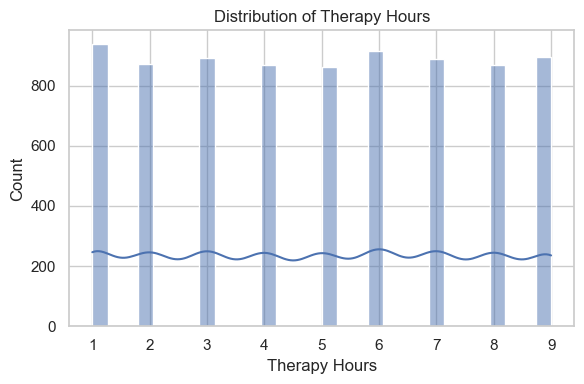

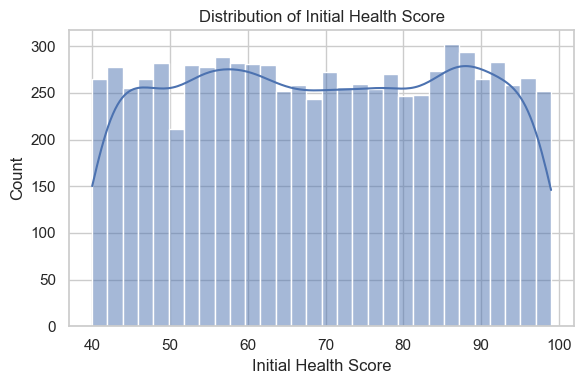

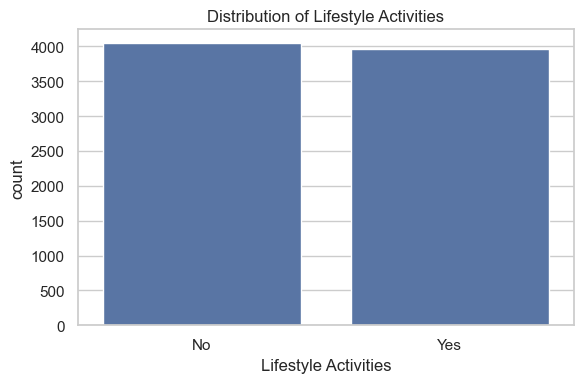

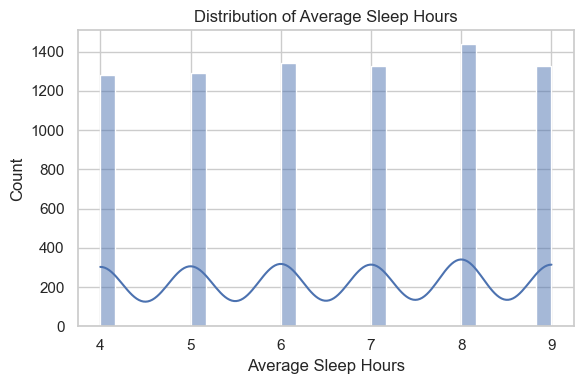

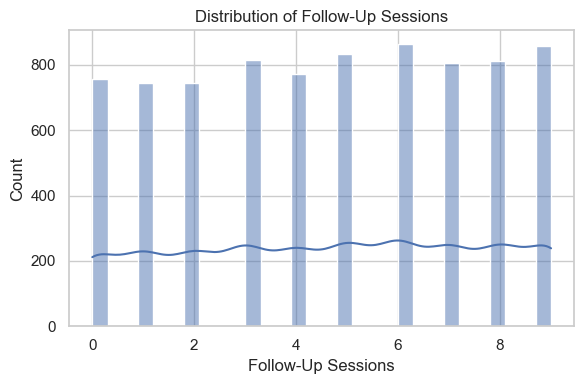

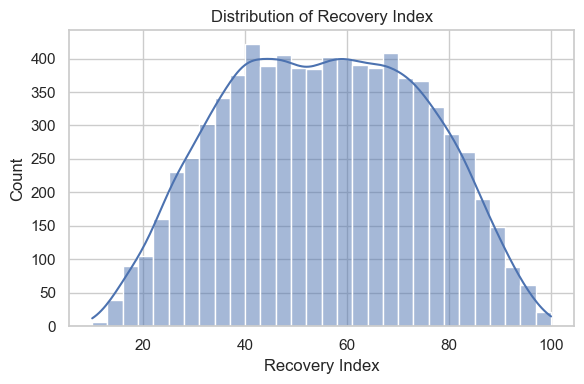

In [5]:

cols_for_hist = [c for c in df.columns if c != 'Id']
for col in cols_for_hist:
    plt.figure(figsize=(6,4))
    if str(df[col].dtype) in ["int64","float64"]:
        sns.histplot(df[col], kde=True, bins=30)
    else:
        sns.countplot(x=df[col])
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()


### 3.2 Box Plots (Outlier Check)


We use box plots to look for obvious outliers in numeric features. No major outliers appear.


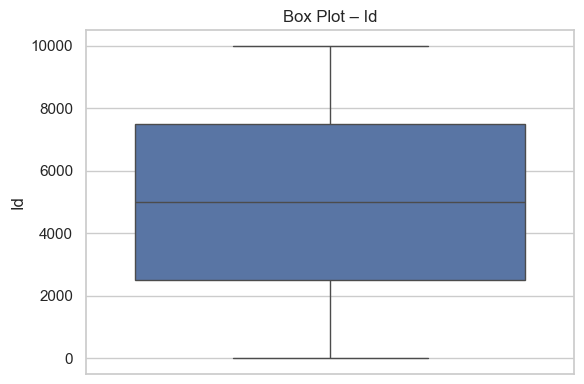

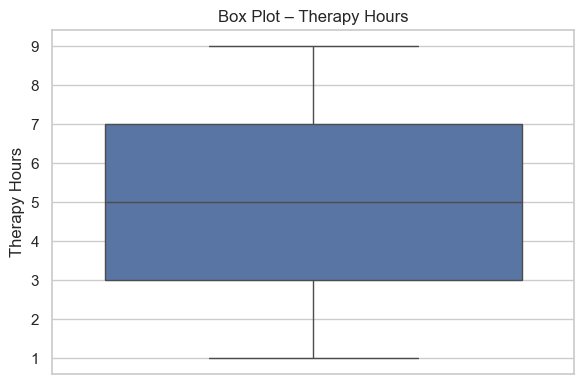

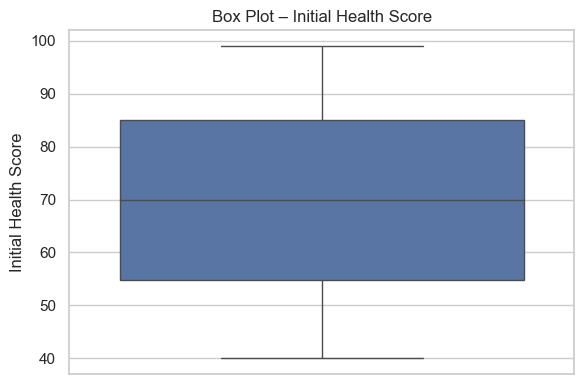

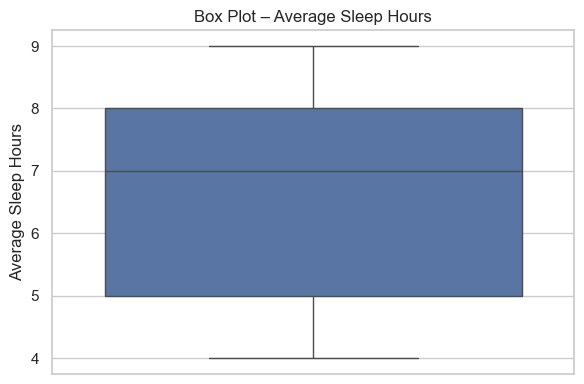

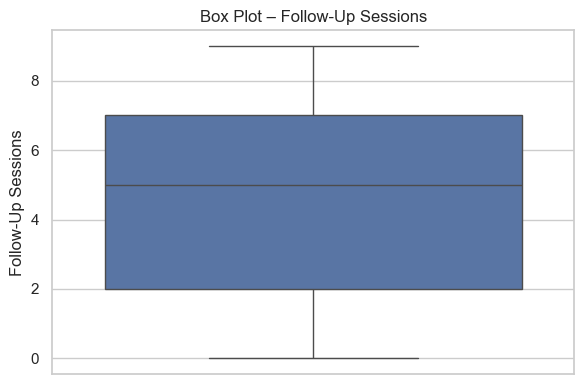

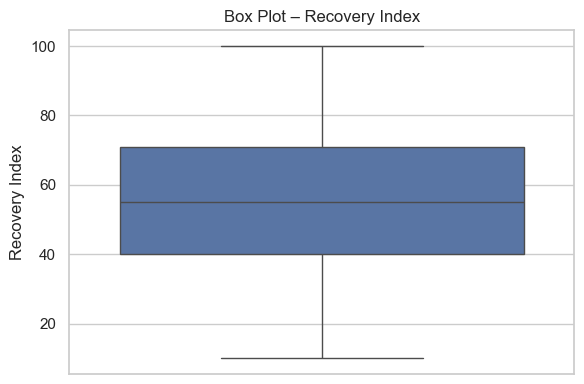

In [6]:

num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=df[col])
    plt.title(f"Box Plot – {col}")
    plt.tight_layout()
    plt.show()


### 3.3 Correlation


We convert **Lifestyle Activities** from Yes/No to 1/0, drop `Id`, and compute the correlation matrix. This shows how strongly each feature moves with the **Recovery Index**.


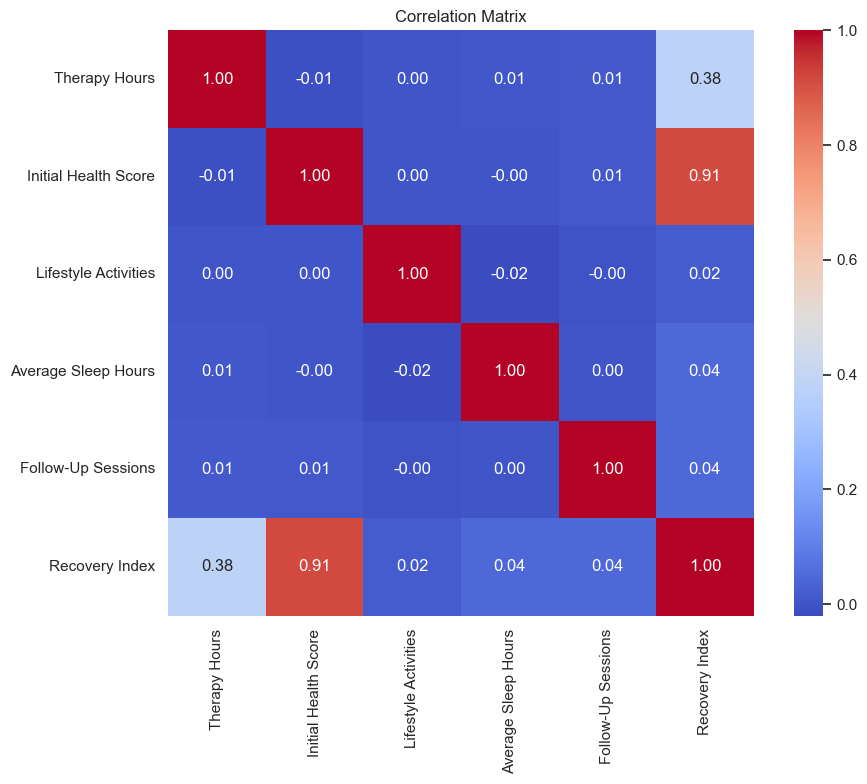


Correlation with Recovery Index (descending):
Recovery Index          1.000000
Initial Health Score    0.914718
Therapy Hours           0.376255
Average Sleep Hours     0.044435
Follow-Up Sessions      0.043888
Lifestyle Activities    0.018690
Name: Recovery Index, dtype: float64


In [7]:

df_corr = df.copy()
if 'Lifestyle Activities' in df_corr.columns:
    df_corr['Lifestyle Activities'] = df_corr['Lifestyle Activities'].map({'Yes':1,'No':0})

data_for_corr = df_corr.drop(columns=['Id']) if 'Id' in df_corr.columns else df_corr
corr = data_for_corr.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

print("\nCorrelation with Recovery Index (descending):")
print(corr['Recovery Index'].sort_values(ascending=False))


## 4. Preprocessing


We select five clear features and encode **Lifestyle Activities** (Yes→1, No→0). For the linear model (Lasso), features are standardized so the regularization treats them fairly. Tree-based models use the unscaled values.


In [8]:

cols = ['Therapy Hours','Initial Health Score','Average Sleep Hours','Follow-Up Sessions','Lifestyle Activities']
X = train[cols].copy()
y = train[TARGET].copy()
T = test[cols].copy()

map_yesno = {'Yes':1, 'No':0, 'yes':1, 'no':0, 'Y':1, 'N':0}
X['Lifestyle Activities'] = X['Lifestyle Activities'].map(map_yesno).fillna(0).astype(float)
T['Lifestyle Activities'] = T['Lifestyle Activities'].map(map_yesno).fillna(0).astype(float)

# Standardization for linear model
mu = X.mean(axis=0)
sigma = X.std(axis=0, ddof=0).replace(0, 1.0)
X_std = (X - mu) / sigma
T_std = (T - mu) / sigma


## 5. Cross‑Validation Setup


We use 10‑fold cross‑validation. The metric is **RMSE** (lower is better). This makes the comparison fair across models.


In [9]:

kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

def cv_rmse(model, X_input, y_input):
    rmses = []
    for tr_idx, va_idx in kf.split(X_input):
        X_tr, X_va = X_input.iloc[tr_idx], X_input.iloc[va_idx]
        y_tr, y_va = y_input.iloc[tr_idx], y_input.iloc[va_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_va)
        rmse = float(np.sqrt(np.mean((y_va - preds)**2)))
        rmses.append(rmse)
    return float(np.mean(rmses))


## 6. Lasso Regression (Linear with L1)


Lasso is a linear model with an L1 penalty. It prefers simpler models by shrinking weaker coefficients. We standardize the inputs and let cross‑validation choose the best strength.


In [10]:

alphas = np.logspace(-4, 1, 60)
lasso = LassoCV(alphas=alphas, cv=10, random_state=RANDOM_STATE, max_iter=20000)
lasso_rmse = cv_rmse(lasso, X_std, y)
print("Lasso CV RMSE:", lasso_rmse)


Lasso CV RMSE: 2.042595466172282


## 6.1 Ridge Regression (Linear with L2)
Ridge uses an L2 penalty to shrink coefficients smoothly. On this dataset, it is expected to perform very similar to Lasso.

In [11]:
alphas = np.logspace(-4, 1, 60)
ridge = RidgeCV(alphas=alphas)
ridge_rmse = cv_rmse(ridge, X_std, y)
print('Ridge (L2) CV RMSE:', ridge_rmse)

Ridge (L2) CV RMSE: 2.042595065956867


## 7. Decision Tree Regressor


A single tree can capture non‑linear splits and feature interactions. It does not need scaling.


In [12]:

tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
tree_rmse = cv_rmse(tree, X, y)
print("Decision Tree CV RMSE:", tree_rmse)


Decision Tree CV RMSE: 3.042496454274987


## 8. Random Forest Regressor


Random Forest builds many trees on bootstrapped samples and averages their predictions to reduce variance and improve stability.


In [13]:

rf = RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
rf_rmse = cv_rmse(rf, X, y)
print("Random Forest CV RMSE:", rf_rmse)


Random Forest CV RMSE: 2.3495342901106993


## 9. AdaBoost Regressor


AdaBoost is a boosting method that learns weak models one after another, focusing more on harder examples to improve accuracy.


In [14]:

ada = AdaBoostRegressor(n_estimators=300, learning_rate=0.05, random_state=RANDOM_STATE)
ada_rmse = cv_rmse(ada, X, y)
print("AdaBoost CV RMSE:", ada_rmse)


AdaBoost CV RMSE: 3.589712769526148


## 10. Model Comparison


We compare the cross‑validated RMSEs in a table and a bar chart. Lower RMSE is better. We then choose the final model.


,Model,CV_RMSE
1,Ridge (Linear L2),2.042595
0,Lasso (Linear L1),2.042595
3,Random Forest,2.349534
2,Decision Tree,3.042496
4,AdaBoost,3.589713


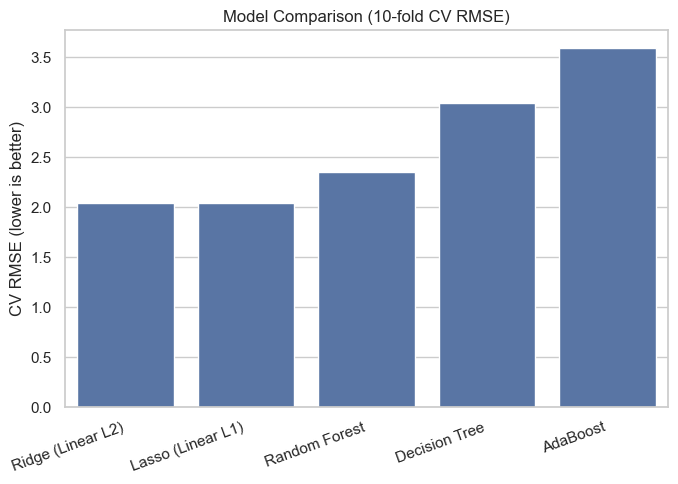

In [15]:

results = pd.DataFrame({
    'Model': ['Lasso (Linear L1)', 'Ridge (Linear L2)', 'Decision Tree', 'Random Forest', 'AdaBoost'],
    'CV_RMSE': [lasso_rmse, ridge_rmse, tree_rmse, rf_rmse, ada_rmse]
}).sort_values('CV_RMSE')

display(results)

plt.figure(figsize=(7,5))
sns.barplot(x='Model', y='CV_RMSE', data=results, order=results['Model'])
plt.title('Model Comparison (10-fold CV RMSE)')
plt.ylabel('CV RMSE (lower is better)')
plt.xlabel('')
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()


## 11. Final Choice and Submission


The chosen model is **Lasso** because it provides strong performance with a simple and interpretable form. We now fit Lasso on all training data and create the submission file.


In [16]:

lasso_full = LassoCV(alphas=np.logspace(-4, 1, 60), cv=10, random_state=RANDOM_STATE, max_iter=20000)
lasso_full.fit(X_std, y)

print("Best alpha:", lasso_full.alpha_)
train_rmse = np.sqrt(mean_squared_error(y, lasso_full.predict(X_std)))
print("Train RMSE (Lasso on full train):", train_rmse)

final_preds = np.clip(lasso_full.predict(T_std), 10, 100)

assert 'Id' in test.columns and test['Id'].is_unique
submission = test[['Id']].copy()
submission['Recovery Index'] = final_preds
submission.to_csv("submission_lasso_simple_scaled.csv", index=False)
print("Saved:", "submission_lasso_simple_scaled.csv")


Best alpha: 0.0001
Train RMSE (Lasso on full train): 2.041993119351484
Saved: submission_lasso_simple_scaled.csv


## 12. Test-Time Predictions for All Models (CSV Export)
This section trains each model on the full training data and writes a CSV of predictions on the test set. Use these files to compare performance externally. If your test data includes the true target, the RMSE will be printed too.

In [17]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import numpy as np, pandas as pd

# 1) Fit models on FULL TRAIN
alphas = np.logspace(-4, 1, 60)

# Linear models on standardized features
lasso_full_test = LassoCV(alphas=alphas, cv=10, random_state=RANDOM_STATE, max_iter=20000)
lasso_full_test.fit(X_std, y)

ridge_full = RidgeCV(alphas=alphas)
ridge_full.fit(X_std, y)

# Tree-based models on unscaled features
tree_full = DecisionTreeRegressor(random_state=RANDOM_STATE)
tree_full.fit(X, y)

rf_full = RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
rf_full.fit(X, y)

ada_full = AdaBoostRegressor(n_estimators=300, learning_rate=0.05, random_state=RANDOM_STATE)
ada_full.fit(X, y)

# 2) Predict on TEST
preds = {
    'lasso': np.clip(lasso_full_test.predict(T_std), 10, 100),
    'ridge': np.clip(ridge_full.predict(T_std), 10, 100),
    'tree':  np.clip(tree_full.predict(T), 10, 100),
    'rf':    np.clip(rf_full.predict(T), 10, 100),
    'ada':   np.clip(ada_full.predict(T), 10, 100),
}

# 3) Write one CSV per model (Id + Recovery Index)
paths = {}

file_names = {
    'lasso': "submission_lasso_model.csv",
    'ridge': "submission_ridge_model.csv",
    'tree':  "submission_decision_tree_model.csv",
    'rf':    "submission_random_forest_model.csv",
    'ada':   "submission_adaboost_model.csv",
}

for name, arr in preds.items():
    out_df = test[['Id']].copy() if 'Id' in test.columns else pd.DataFrame({'Id': np.arange(len(arr))})
    out_df['Recovery Index'] = arr
    path = file_names[name]
    out_df.to_csv(path, index=False)
    paths[name] = path
    print(f"Saved: {path}")
    display(out_df.head())

# 4) Also write a combined file for side-by-side comparison
combo = test[['Id']].copy() if 'Id' in test.columns else pd.DataFrame({'Id': np.arange(len(next(iter(preds.values()))))})
combo['Lasso'] = preds['lasso']
combo['Ridge'] = preds['ridge']
combo['DecisionTree'] = preds['tree']
combo['RandomForest'] = preds['rf']
combo['AdaBoost'] = preds['ada']
combo_path = "predictions_all_models.csv"
combo.to_csv(combo_path, index=False)
print(f"Saved combined file: {combo_path}")
display(combo.head())

# 5) Optional: if test has ground-truth target, print RMSE for each (using clipped preds)
if TARGET in test.columns:
    y_true = test[TARGET].values
    def rmse(a, b):
        return float(np.sqrt(np.mean((a - b)**2)))
    print("\nTest RMSE (if ground truth in test):")
    for name, arr in preds.items():
        print(f"  {name}: {rmse(y_true, arr):.6f}")


Saved: submission_lasso_model.csv


,Id,Recovery Index
0,6253,54.711959
1,4685,22.615696
2,1732,47.903003
3,4743,31.289684
4,4522,43.004794


Saved: submission_ridge_model.csv


,Id,Recovery Index
0,6253,54.711856
1,4685,22.615728
2,1732,47.903193
3,4743,31.289923
4,4522,43.004649


Saved: submission_decision_tree_model.csv


,Id,Recovery Index
0,6253,57.0
1,4685,24.0
2,1732,45.0
3,4743,27.0
4,4522,45.0


Saved: submission_random_forest_model.csv


,Id,Recovery Index
0,6253,56.108333
1,4685,22.014444
2,1732,46.380000
3,4743,29.361444
4,4522,42.656889


Saved: submission_adaboost_model.csv


,Id,Recovery Index
0,6253,53.687195
1,4685,23.357370
2,1732,49.954849
3,4743,33.590529
4,4522,46.258844


Saved combined file: predictions_all_models.csv


,Id,Lasso,Ridge,DecisionTree,RandomForest,AdaBoost
0,6253,54.711959,54.711856,57.0,56.108333,53.687195
1,4685,22.615696,22.615728,24.0,22.014444,23.357370
2,1732,47.903003,47.903193,45.0,46.380000,49.954849
3,4743,31.289684,31.289923,27.0,29.361444,33.590529
4,4522,43.004794,43.004649,45.0,42.656889,46.258844
